# Breast Cancer Detection

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import RandomOverSampler

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score

## Fetching dataset

In [3]:
# Fetch data
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
breast_cancer_X=pd.DataFrame(X)
display(breast_cancer_X[:5])

y = breast_cancer_wisconsin_diagnostic.data.targets 
breast_cancer_y=pd.DataFrame(y)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
breast_cancer_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

## Looking at balance of data 

In [5]:
malignant = np.sum(y['Diagnosis'] == 'M')
benign  = np.sum(y['Diagnosis'] == 'B')
print("Number of benign cases: ", benign)
print("Number of malignant cases: ", malignant)

Number of benign cases:  357
Number of malignant cases:  212


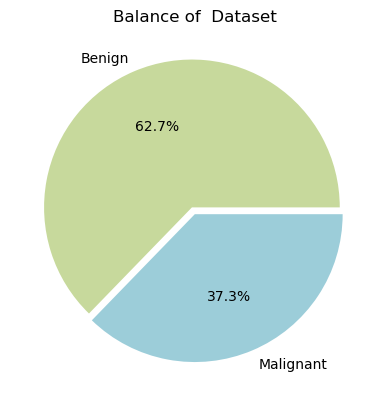

In [6]:
labels = ['Benign', 'Malignant']
counts = [benign, malignant]
colors = ['#c7d99c', '#9ccdd9']
breakpoint = (0.05, 0)
plt.pie(counts,explode=breakpoint,colors=colors, labels=labels, autopct='%1.1f%%')
plt.title('Balance of  Dataset')
plt.show()

## Balancing the dataset by oversampling

### Oversampling 

In [7]:
balanced = RandomOverSampler(sampling_strategy='minority')
balanced_X, balanced_y = balanced.fit_resample(breast_cancer_X,breast_cancer_y)

In [8]:
malignant = np.sum(balanced_y['Diagnosis'] == 'M')
benign  = np.sum(balanced_y['Diagnosis'] == 'B')
print("Number of benign cases: ", benign)
print("Number of malignant cases: ", malignant)

Number of benign cases:  357
Number of malignant cases:  357


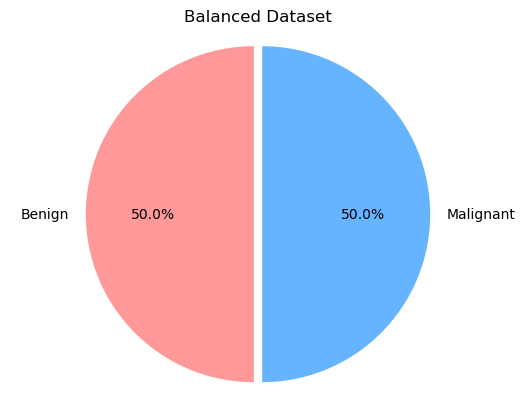

In [9]:
sizes = [benign, malignant]
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Balanced Dataset')
plt.show()

In [10]:
# Pre-processing
balanced_y['Diagnosis'] = balanced_y['Diagnosis'].map({'M': 1, 'B': 0})

### Splitting the dataset 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.2, random_state=42)

In [12]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Hyperparameter Tuning for Each Model

In [13]:
# K fold cross validation 
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# these dictionaries are going to store the best params
best_param_logistic={}
best_param_DT ={}
best_param_RF={}
best_param_bayesian={} 
best_param_knn={}

### Logistic regression 

In [14]:
bal_logistic = LogisticRegression(solver='lbfgs', max_iter=20000,random_state=42)

logistic_param_grid = {
    'solver' :['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C' :[100, 10, 1.0, 0.1, 0.01]
}

logistic_grid_search = GridSearchCV(estimator=bal_logistic, param_grid=logistic_param_grid, cv=k_fold, scoring='accuracy')
logistic_grid_search.fit(X_train, y_train)
logistic_best_model = logistic_grid_search.best_estimator_
logistic_val_accuracy = logistic_best_model.score(X_test, y_test)
best_param_logistic=logistic_grid_search.best_params_

print('Logistic Regression')
print('Best Parameters:', best_param_logistic)
print('Validation Accuracy:', logistic_val_accuracy)

Logistic Regression
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.986013986013986


### Decision tree 

In [15]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
print("Max Depth:", decision_tree.tree_.max_depth)

Max Depth: 6


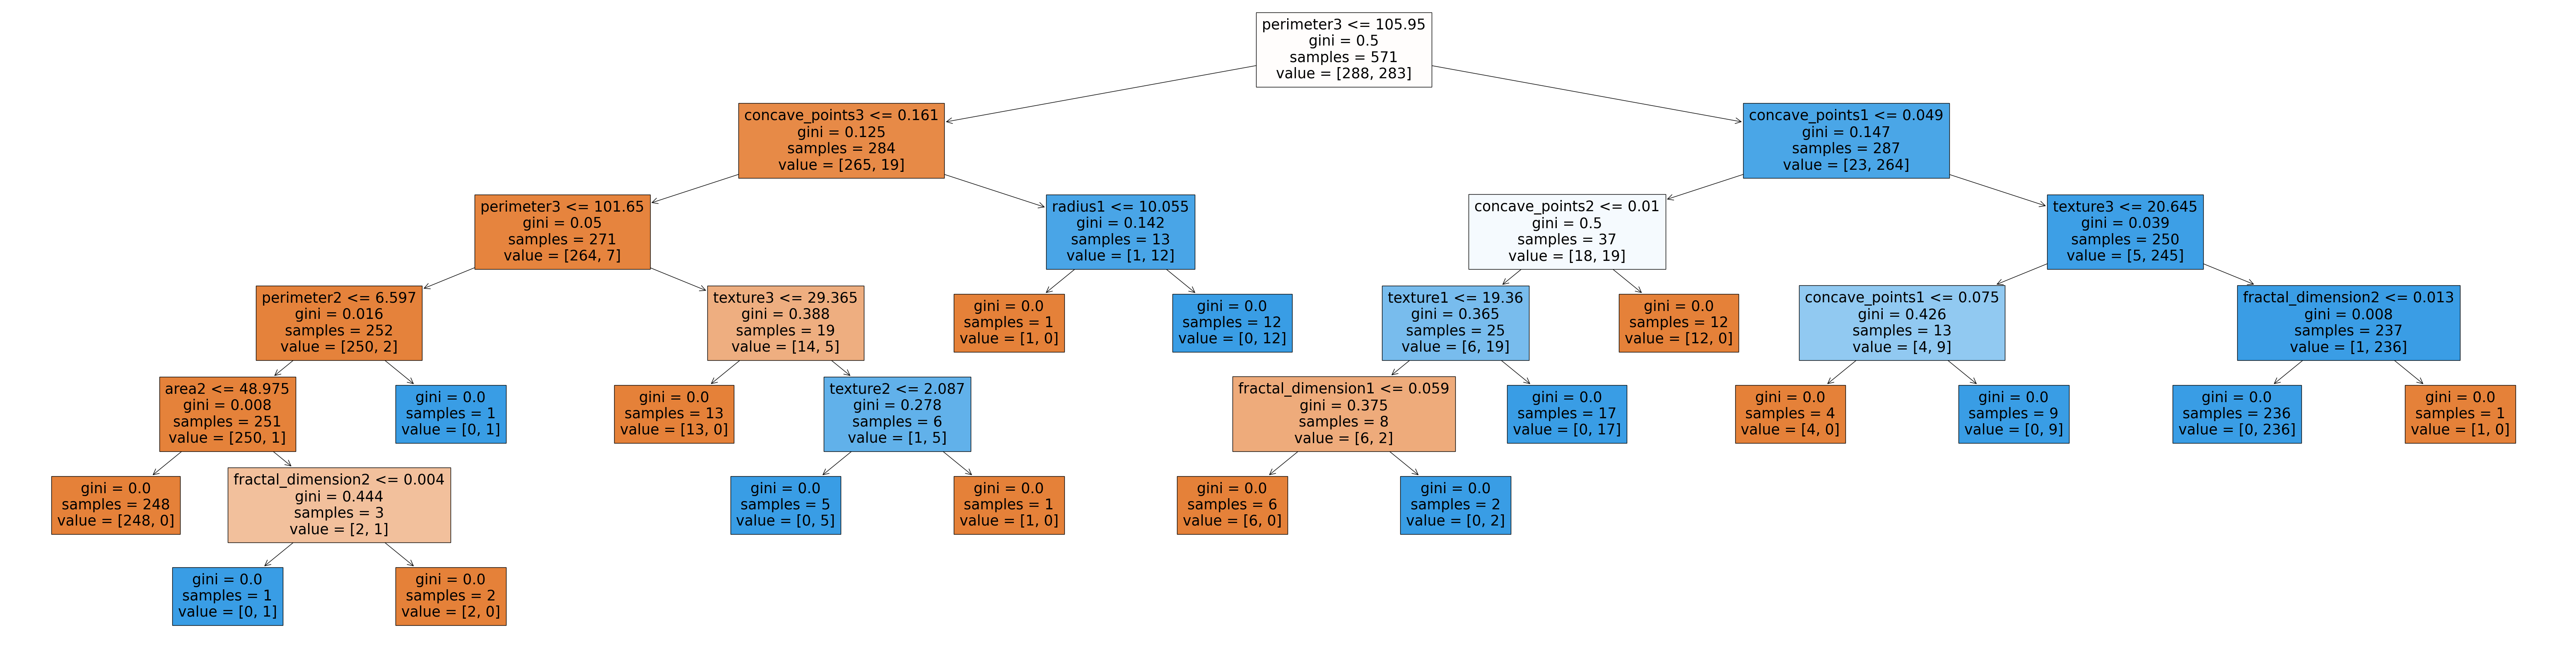

In [16]:
plt.figure(figsize=(80, 20))
plot_tree(decision_tree, feature_names=X_train.columns, filled=True)
plt.show()

In [17]:
tree= DecisionTreeClassifier(random_state=42)
tree_param_grid = {'max_depth': range(1, 11),
                   'min_samples_split': [2,5,10],
                   'min_samples_leaf': [1, 2, 4, 6]
                  }

tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=k_fold, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)
tree_best_model = tree_grid_search.best_estimator_
tree_val_accuracy = tree_best_model.score(X_test, y_test)
best_param_DT=tree_grid_search.best_params_

print('Decision Tree')
print('Best Parameters:',best_param_DT)
print('Validation Accuracy:', tree_val_accuracy)

Decision Tree
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Accuracy: 0.9790209790209791


### Random Forest 

In [18]:
random_forest= RandomForestClassifier(random_state=42)
random_param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': range(1, 11),
    'max_leaf_nodes': [3,6,9]
} 

random_grid_search= GridSearchCV(random_forest, random_param_grid, cv=k_fold, scoring='accuracy')
random_grid_search.fit(X_train, y_train)
random_best_model = random_grid_search.best_estimator_
random_val_accuracy =random_best_model.score(X_test, y_test)
best_param_RF=random_grid_search.best_params_

print('Random Forest')
print('Best Parameters:', best_param_RF)
print('Validation Accuracy:', random_val_accuracy)

Random Forest
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}
Validation Accuracy: 0.951048951048951


### Bayesian Classification 

In [19]:
bayesian = GaussianNB()
bayesian_param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
bayesian_grid_search= GridSearchCV(bayesian, bayesian_param_grid, cv=k_fold, scoring='accuracy')
bayesian_grid_search.fit(X_train, y_train)
bayesian_best_model = bayesian_grid_search.best_estimator_
bayesian_val_accuracy = bayesian_best_model.score(X_test, y_test)
best_param_bayesian=bayesian_grid_search.best_params_
print('Bayesian Classification')
print('Best Parameters:', best_param_bayesian)
print('Validation Accuracy:', bayesian_val_accuracy)

Bayesian Classification
Best Parameters: {'var_smoothing': 1.2328467394420635e-09}
Validation Accuracy: 0.9230769230769231


### k-Nearest Neighbours

#### My own implementation of the KNN function and k-fold cross-validation.
To optimise the KNN classifier, I experimented with different distance metrics (Euclidean, Manhattan, Minkowski) and varied the number of neighbours (1 to 7 odd numbers) . In addition, the distance metrics and test train split were also written by me.

In [20]:
# my distance metrics 
def euclidean_distance(a, b):
    euclidean_distance = np.sqrt(np.sum((a-b)**2))
    return euclidean_distance

def manhattan_distance(a, b):
    manhattan_distance = 0
    for i in range(0, len(a)):
        manhattan_distance += math.fabs(a[i] - b[i])
    return manhattan_distance

def minkowski_distance(a,b): 
    #power set to 2 as default
    p=2
    minkowski_distance = np.power(np.sum(np.abs(a - b)**p), 1/p)
    return minkowski_distance

In [21]:
def myKNN(X, y, X_, method, k):
    predicted = []
    calculated_Dis = []

    for a in X_:
        if method == 'euclidean':
            calculated_Dis = [euclidean_distance(a, b) for b in X]
        elif method == 'manhattan':
            calculated_Dis = [manhattan_distance(a, b) for b in X]
        elif method == 'minkowski':
            calculated_Dis = [minkowski_distance(a, b) for b in X]
        else:
            print('Error: Wrong distance metrics entered')

        nearestK_index = np.argsort(calculated_Dis)[:k]
        nearestK_classes = [y[i] for i in nearestK_index]
        nearestK_classes = np.asarray(nearestK_classes).flatten().astype(int)
        counts = np.bincount(nearestK_classes)
        predicted.append(np.argmax(counts))

    return np.array(predicted)

In [22]:
def my_cross_validation(X, y, k_range, k_fold, param):
    X = np.array(X)
    y = np.array(y)
    best_accuracy=0
    
    np.random.seed(42)
    indicesarray = np.arange(X.shape[0])
    shuffled_indices = np.random.permutation(indicesarray)
    folds = np.array_split(shuffled_indices, k_fold)

    optimal_result = {
        'optimal_k': None,
        'optimal_dist_met':None,
        'average_accuracy': 0,
    }
    
    for dist_met in param: 

        for k in k_range:
            KNN_result = {
                'test_accuracy': [],
            }

            for i in range(k_fold):
                training_indices = []
                testing_indices = []

                for j in range(k_fold):
                    if i == j:
                        testing_indices = folds[i]
                    else:
                        training_indices.extend(folds[j])

                X_train, y_train = X[training_indices], y[training_indices]
                X_test, y_test = X[testing_indices], y[testing_indices]

                y_pred = myKNN(X_train, y_train, X_test,dist_met, k)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)

                KNN_result['test_accuracy'].append(accuracy)

            average_accuracy = np.mean(KNN_result['test_accuracy'])
            
            if average_accuracy > optimal_result['average_accuracy']:
                optimal_result['optimal_k'] = k
                optimal_result['optimal_dist_met'] = dist_met
                optimal_result['average_accuracy'] = average_accuracy
                
    return optimal_result

In [23]:
k_range = k_range = [1, 3, 5, 7]
distance_metrics=['euclidean','manhattan','minkowski']
best_param_knn=my_cross_validation(balanced_X, balanced_y, k_range,5,distance_metrics)
print('KNN')
print(best_param_knn)

KNN
{'optimal_k': 1, 'optimal_dist_met': 'manhattan', 'average_accuracy': 0.9579730129025904}


## Retraining the model and Performance Analysis

In [24]:
balanced_table = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1_score'])

def evaluation(algo_name, y_pred, y_test):
    global balanced_table

    logistic_test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    formatted_accuracy = "{:.1f}%".format(logistic_test_accuracy * 100)
    formatted_precision = "{:.1f}%".format(precision * 100)
    formatted_recall = "{:.1f}%".format(recall * 100)
    formatted_f1 = "{:.1f}%".format(f1 * 100)

    print(f'Evaluation for {algo_name}')
    print(f"\nAccuracy   : {formatted_accuracy}    ({logistic_test_accuracy:.3f})")
    print(f"Precision  : {formatted_precision}   ({precision:.3f})")
    print(f"Recall     : {formatted_recall}    ({recall:.3f})")
    print(f"F1_score   : {formatted_f1}    ({f1:.3f})")
    print('Confusion matrix:')
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, cmap='GnBu', linewidths=.1)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    new_data = pd.DataFrame({
        'Algorithm': [algo_name],
        'Accuracy': [formatted_accuracy],
        'Precision': [formatted_precision],
        'Recall': [formatted_recall],
        'F1_score': [formatted_f1],
    })

    if algo_name not in balanced_table['Algorithm'].values:
        balanced_table = pd.concat([balanced_table.reset_index(drop=True), new_data], axis=0, ignore_index=True)

### Logistic regression 

Evaluation for Logistic regression

Accuracy   : 98.6%    (0.986)
Precision  : 100.0%   (1.000)
Recall     : 97.3%    (0.973)
F1_score   : 98.6%    (0.986)
Confusion matrix:


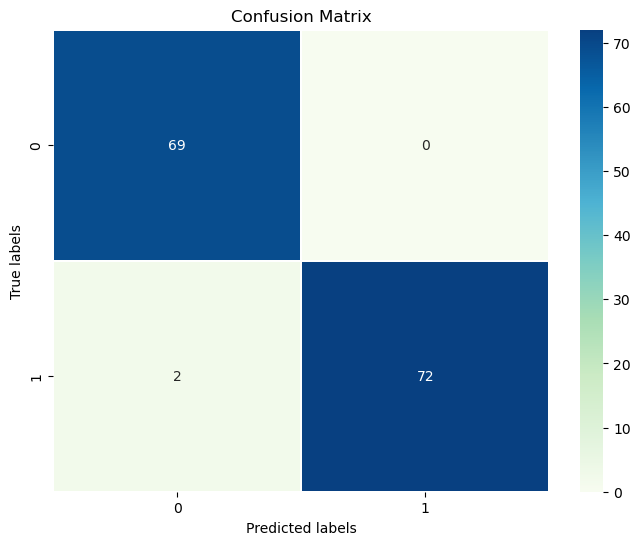

In [25]:
best_logistic = LogisticRegression(solver=best_param_logistic['solver'],
                                   penalty=best_param_logistic['penalty'],
                                   C=best_param_logistic['C'],
                                   max_iter=10000,
                                   random_state=42)

best_logistic.fit(X_train, y_train)
logistic_pred = best_logistic.predict(X_test)
evaluation('Logistic regression',logistic_pred,y_test)

### Random Forest 

Evaluation for Random Forest

Accuracy   : 95.1%    (0.951)
Precision  : 93.5%   (0.935)
Recall     : 97.3%    (0.973)
F1_score   : 95.4%    (0.954)
Confusion matrix:


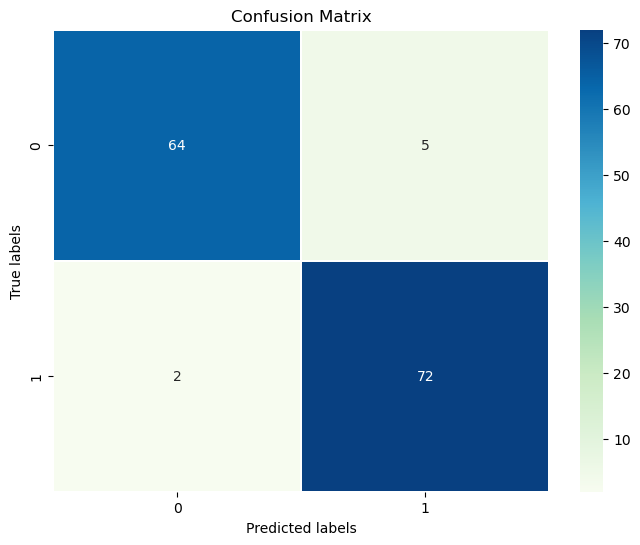

In [26]:
best_random_forest = RandomForestClassifier(n_estimators=best_param_RF['n_estimators'],
                                            max_features=best_param_RF['max_features'],
                                            max_depth=best_param_RF['max_depth'],
                                            max_leaf_nodes=best_param_RF['max_leaf_nodes'],
                                            random_state=42)

best_random_forest.fit(X_train, y_train)
forest_pred = best_random_forest.predict(X_test)
evaluation('Random Forest',forest_pred,y_test)

### Decision Tree 

Evaluation for Decision Tree

Accuracy   : 97.9%    (0.979)
Precision  : 98.6%   (0.986)
Recall     : 97.3%    (0.973)
F1_score   : 98.0%    (0.980)
Confusion matrix:


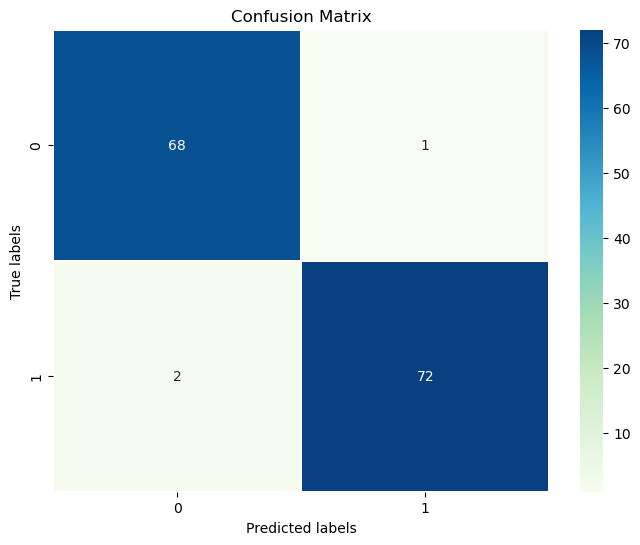

In [27]:
best_tree = DecisionTreeClassifier(max_depth=best_param_DT['max_depth'],
                                   min_samples_split=best_param_DT['min_samples_split'],
                                   min_samples_leaf=best_param_DT['min_samples_leaf'],
                                   random_state=42)

best_tree.fit(X_train, y_train)
tree_pred = best_tree.predict(X_test)
evaluation('Decision Tree',tree_pred,y_test)

### Bayesian classification

Evaluation for Bayesian Classification

Accuracy   : 92.3%    (0.923)
Precision  : 100.0%   (1.000)
Recall     : 85.1%    (0.851)
F1_score   : 92.0%    (0.920)
Confusion matrix:


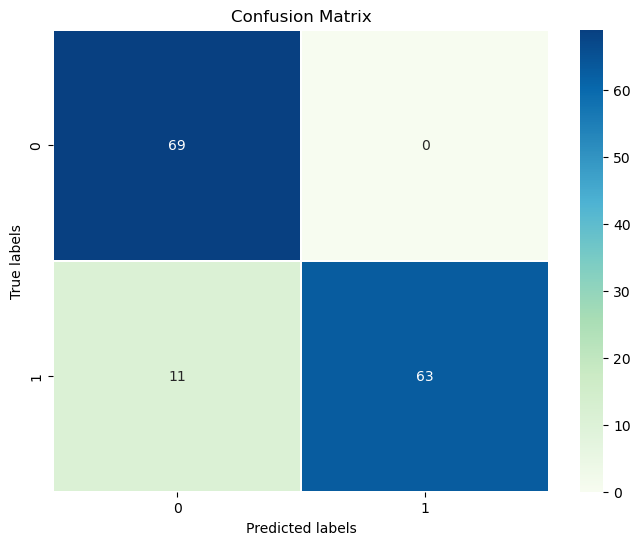

In [28]:
best_bayesian = GaussianNB(var_smoothing=best_param_bayesian['var_smoothing'])
best_bayesian.fit(X_train, y_train)
bayesian_pred = best_bayesian.predict(X_test)
evaluation('Bayesian Classification',bayesian_pred,y_test)

### k-Nearest Neighbours

Evaluation for k-Nearest Neighbours

Accuracy   : 97.2%    (0.972)
Precision  : 97.3%   (0.973)
Recall     : 97.3%    (0.973)
F1_score   : 97.3%    (0.973)
Confusion matrix:


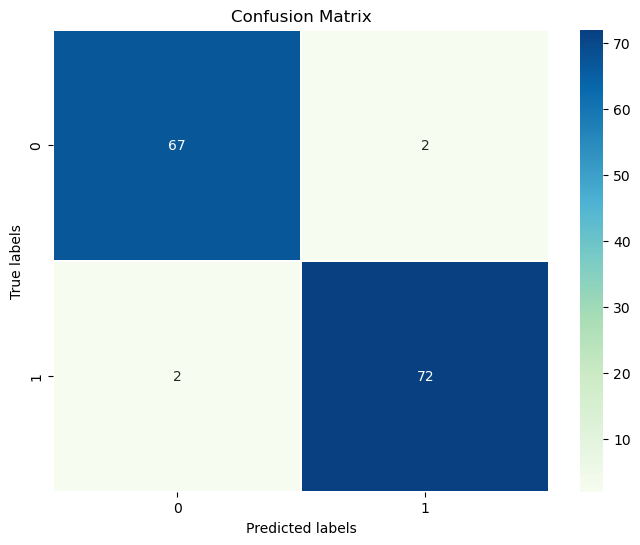

In [29]:
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
X_test_np=np.array(X_test)
y_test_np=np.array(y_test)
knn_pred=myKNN(X_train_np, y_train_np, X_test_np,best_param_knn['optimal_dist_met'], best_param_knn['optimal_k'])
evaluation('k-Nearest Neighbours',knn_pred,y_test_np)

## Final Retrained Model Evaluation Metrics

In [30]:
display(balanced_table)

,Algorithm,Accuracy,Precision,Recall,F1_score
0,Logistic regression,98.6%,100.0%,97.3%,98.6%
1,Random Forest,95.1%,93.5%,97.3%,95.4%
2,Decision Tree,97.9%,98.6%,97.3%,98.0%
3,Bayesian Classification,92.3%,100.0%,85.1%,92.0%
4,k-Nearest Neighbours,97.2%,97.3%,97.3%,97.3%


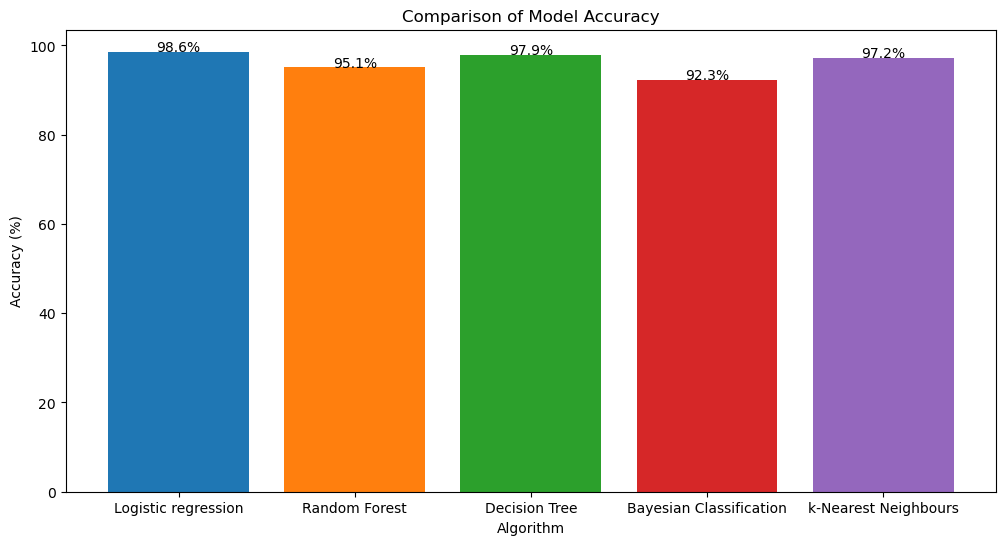

In [32]:
models = balanced_table['Algorithm']
accuracy = balanced_table['Accuracy']

accuracy = accuracy.str.rstrip('%').astype('float')

bar_colors =  ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD']
plt.figure(figsize=(12, 6))
plt.bar(models, accuracy, color=bar_colors)

plt.xlabel('Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracy')

for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.1, f'{acc:.1f}%', ha='center')

plt.show()
